In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
from pathlib import Path
import os
import pandas as pd
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json





from utils import create_uniform_energy_grid, shift_test_batch
from models import MultiClassifierV2_STN



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Optionally, you can print more details about the GPU if available
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")

/home/issa/new_project_clone/GenXPS_public/genXPS/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
GPU Name: Tesla T4
Number of GPUs available: 1


In [2]:

start_energy = 40
end_energy = 700
BE_values = create_uniform_energy_grid(start_energy, end_energy)

In [3]:
import torch

# Load the entire dictionary object
test_data = torch.load('../data/synthetic_data_hard_final/test_data.pt')

# Access each item by its key
X_test = test_data['features']
y_test = test_data['labels']


# Now you can use these tensors for evaluation
print(f"Loaded features shape: {X_test.shape}")
print(f"Loaded labels shape: {y_test.shape}")


Loaded features shape: torch.Size([20000, 6601])
Loaded labels shape: torch.Size([20000, 40])


In [4]:

# 4. Create an instance of the model and send it to target device
model_0 = MultiClassifierV2_STN().to(device)

# Load the saved model
model_path = Path("../../../local_models/STN_3_shift.pth")


model_0.load_state_dict(torch.load(model_path))
model_0.eval()

MultiClassifierV2_STN(
  (stn): STN1D(
    (localization): Sequential(
      (0): Linear(in_features=6601, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=32, out_features=2, bias=True)
    )
  )
  (layer_1): Linear(in_features=6601, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_3): Linear(in_features=128, out_features=40, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [5]:
mean_spectrum_baseline = X_test.mean(0, keepdim=True).to(device)

--- Prediction Summary for Sample #3 ---
   Functional Group  Actual  Predicted
alcohol (aliphatic)     1.0        1.0
  ether (aliphatic)     1.0        1.0
  ester (aliphatic)     1.0        1.0
             alkane     0.0        1.0
---------------------------------------------

Found 4 positive predictions. Generating explanations...


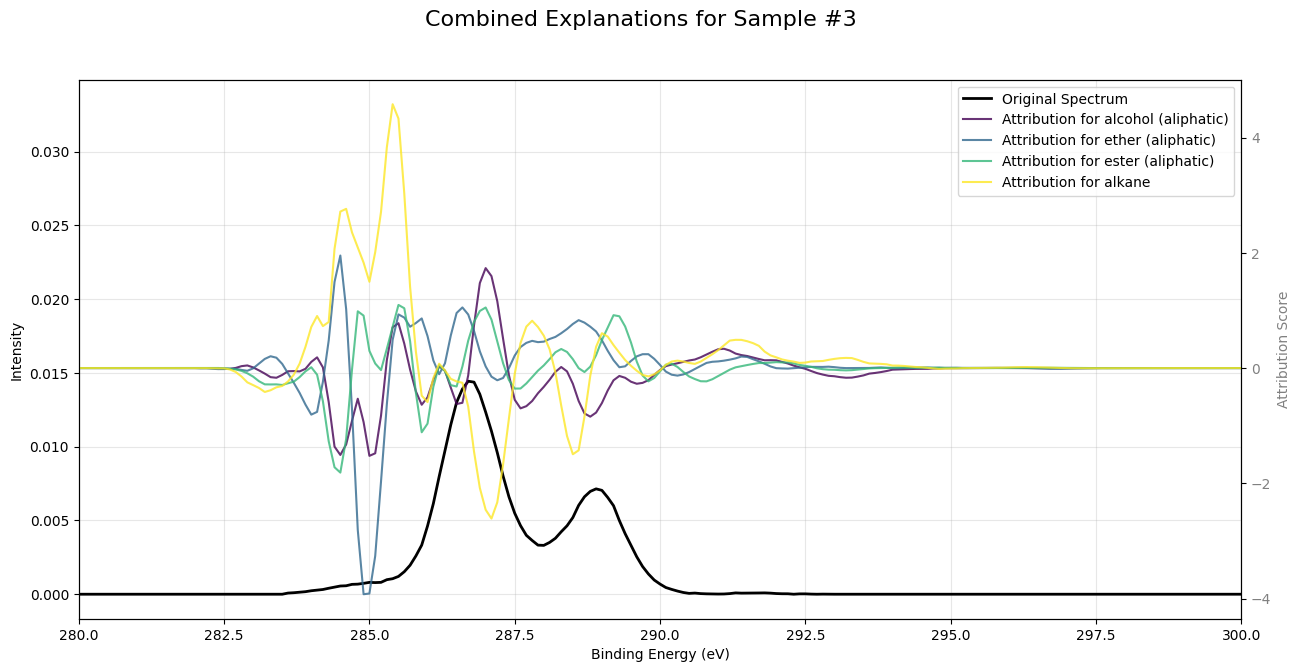

In [ ]:

# --- 1. Setup & Data Preparation ---
# Assume FG_list, model_0, X_test, y_test, BE_values, and device are defined

# Select a single spectrum and its true label
SAMPLE_INDEX = 3
input_spectrum = X_test[SAMPLE_INDEX].unsqueeze(0).to(device)
true_labels = y_test[SAMPLE_INDEX].to(device)
input_spectrum.requires_grad = True

# --- 2. Get Model Predictions for the Input Spectrum ---
model_0.eval()
with torch.inference_mode():
    logits, _ = model_0(input_spectrum)
    predictions = torch.round(torch.sigmoid(logits)).squeeze()


# --- Create and Display a Prediction Summary DataFrame ---
true_labels_np = true_labels.cpu().numpy()
predictions_np = predictions.cpu().numpy()

with open("../data/FG_list.json", "r") as f:
    FG_list= json.load(f)


df = pd.DataFrame({
    'Functional Group': FG_list,
    'Actual': true_labels_np,
    'Predicted': predictions_np
})

summary_df = df[(df['Actual'] == 1) | (df['Predicted'] == 1)]

print("--- Prediction Summary for Sample #{} ---".format(SAMPLE_INDEX))
print(summary_df.to_string(index=False))
print("-" * 45)
# ----------------------------------------------------------------

# --- 3. Compute and Plot Attributions for Each Positive Class ---
positive_class_indices = torch.where(predictions == 1)[0]

if len(positive_class_indices) == 0:
    print("\nNo positive classes were predicted for this spectrum.")
else:
    print(f"\nFound {len(positive_class_indices)} positive predictions. Generating explanations...")
    
    # Setup the explainer
    forward_func = lambda x: model_0(x)[0]
    ig = IntegratedGradients(forward_func)
    
    # --- NEW: Create a single plot for all attributions ---
    fig, ax1 = plt.subplots(figsize=(15, 7))
    fig.suptitle(f"Combined Explanations for Sample #{SAMPLE_INDEX}", fontsize=16)
    
    # Plot the original spectrum on the primary y-axis
    original_spec_np = input_spectrum.squeeze(0).cpu().detach().numpy()
    ax1.plot(BE_values, original_spec_np, label='Original Spectrum', color='black', linewidth=2)
    ax1.set_xlabel("Binding Energy (eV)")
    ax1.set_ylabel("Intensity", color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, alpha=0.3)
    
    # Create a second y-axis for the attribution scores
    ax2 = ax1.twinx()
    ax2.set_ylabel("Attribution Score", color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    # Define a colormap to get unique colors for each class
    colors = cm.viridis(np.linspace(0, 1, len(positive_class_indices)))

    # Loop through positive classes, compute attribution, and plot on the same axes
    for i, class_index in enumerate(positive_class_indices):
        attribution = ig.attribute(input_spectrum,
                           baselines=mean_spectrum_baseline,
                           target=class_index.item())
        
        attribution_np = attribution.squeeze(0).cpu().detach().numpy()
        functional_group_name = FG_list[class_index]
        
        # Plot the attribution score on the secondary y-axis with a unique color
        ax2.plot(BE_values, attribution_np, label=f'Attribution for {functional_group_name}', color=colors[i], alpha=0.8)

    # --- Finalize and show the combined plot ---
    # Create a single legend for all lines on the plot
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    
    plt.xlim(280,300) # Optional zoom
    plt.show()



--- Prediction Summary for Sample #12 ---
Functional Group  Actual  Predicted
    benzene ring     1.0        1.0
alkyl halide (F)     1.0        1.0
       sulfonate     1.0        1.0
          alkane     1.0        1.0
---------------------------------------------

Found 4 positive predictions. Generating explanations...


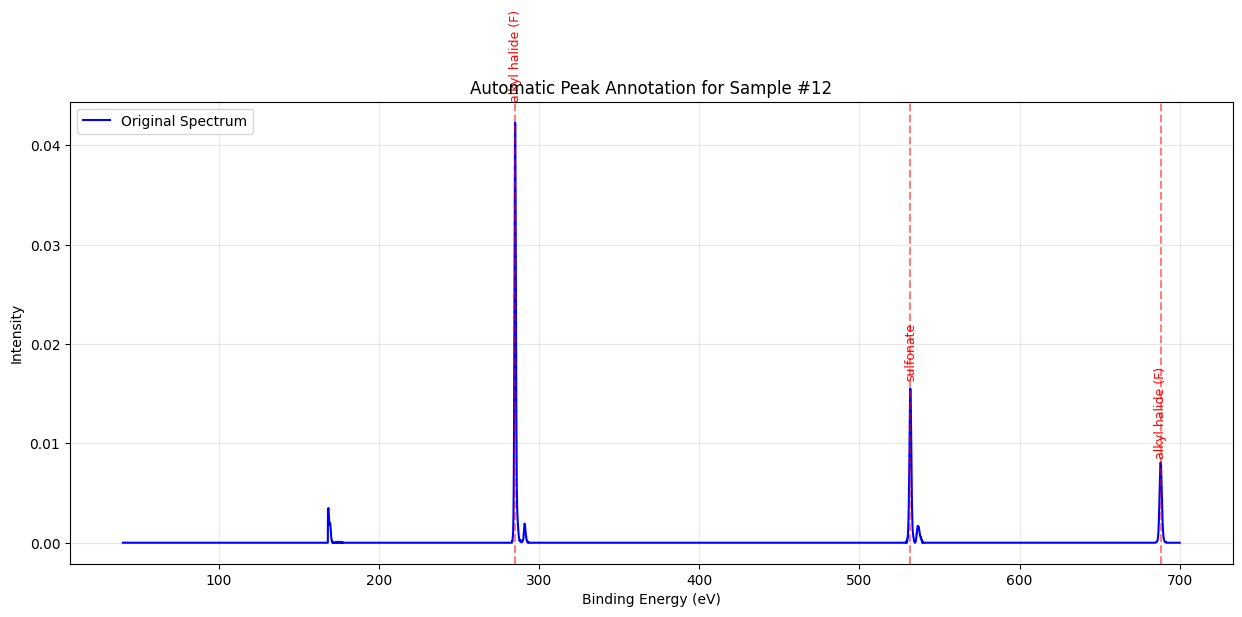

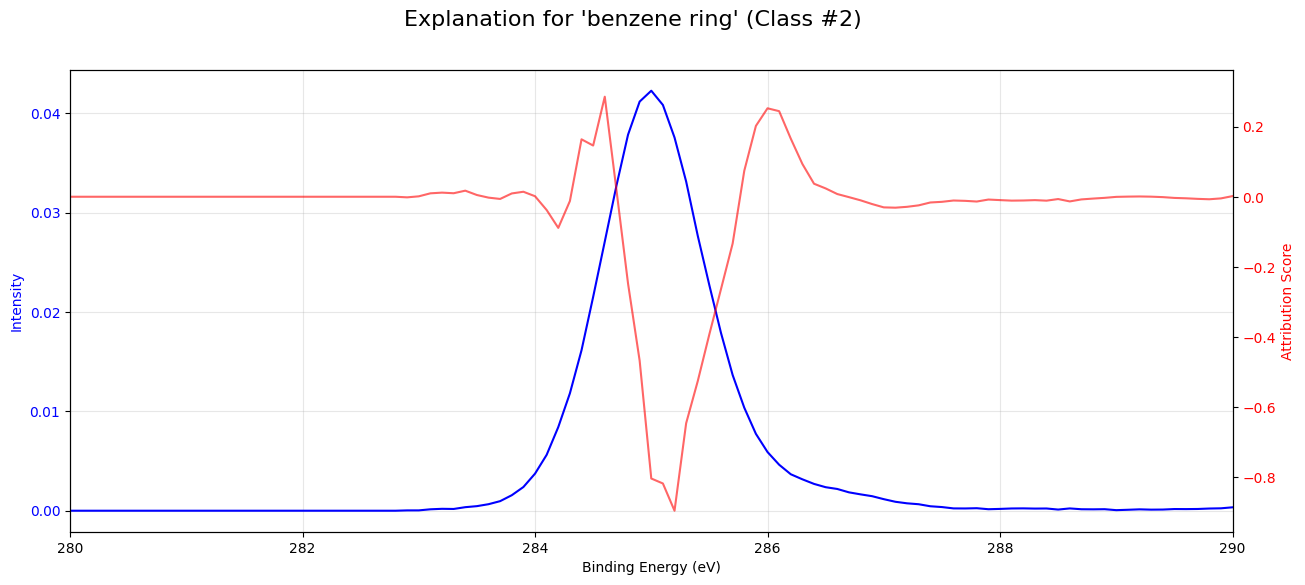

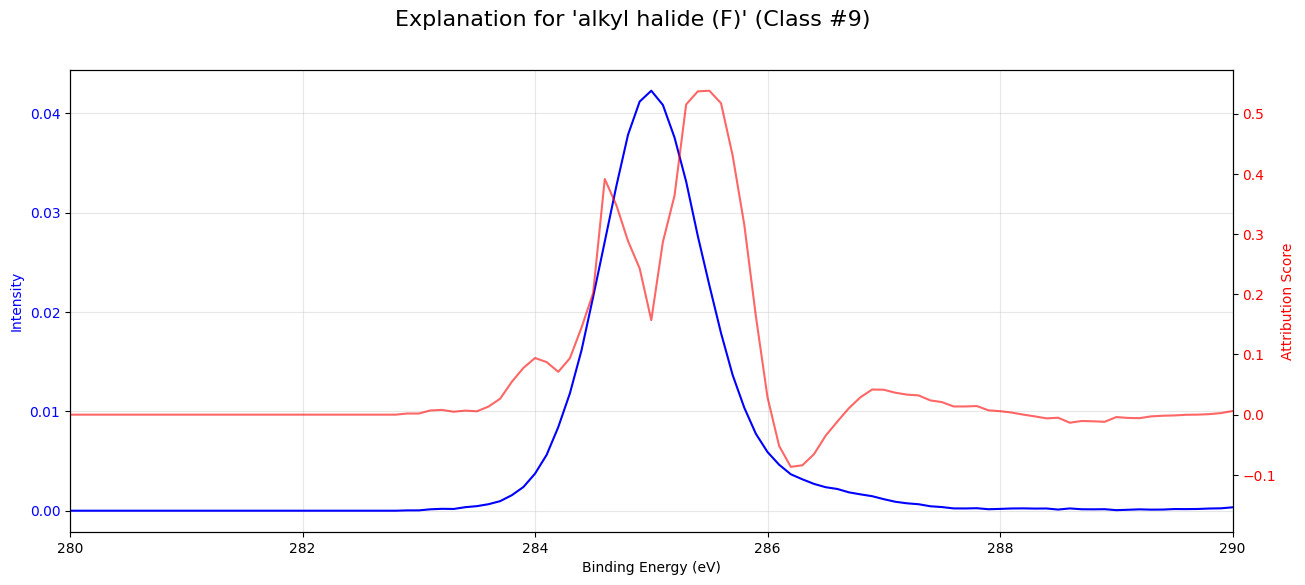

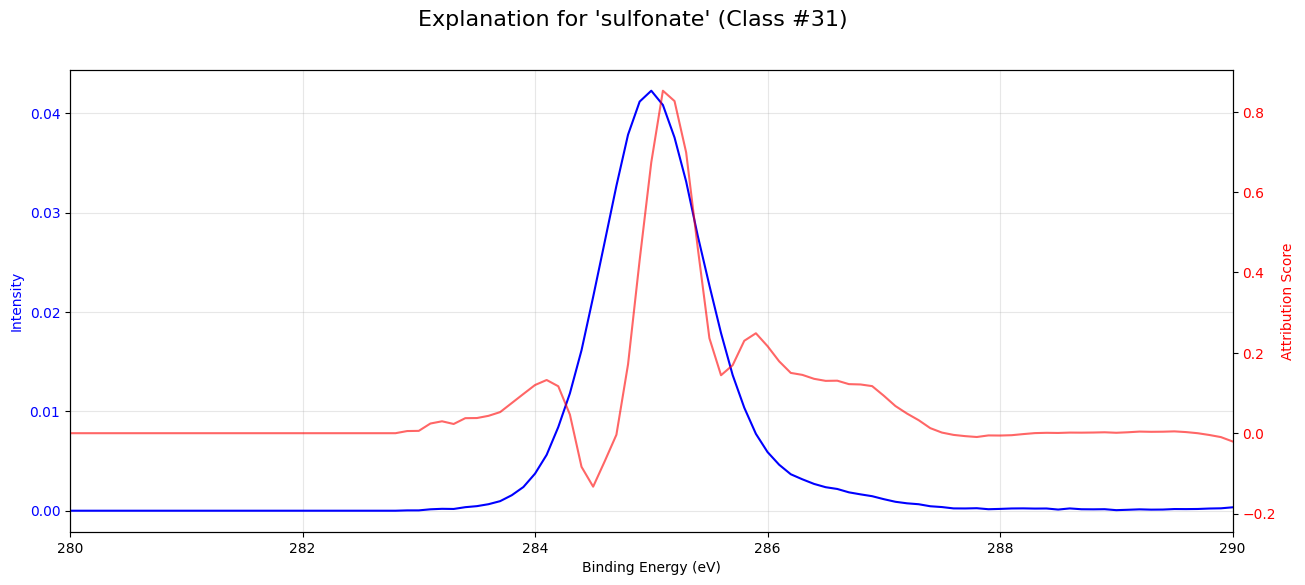

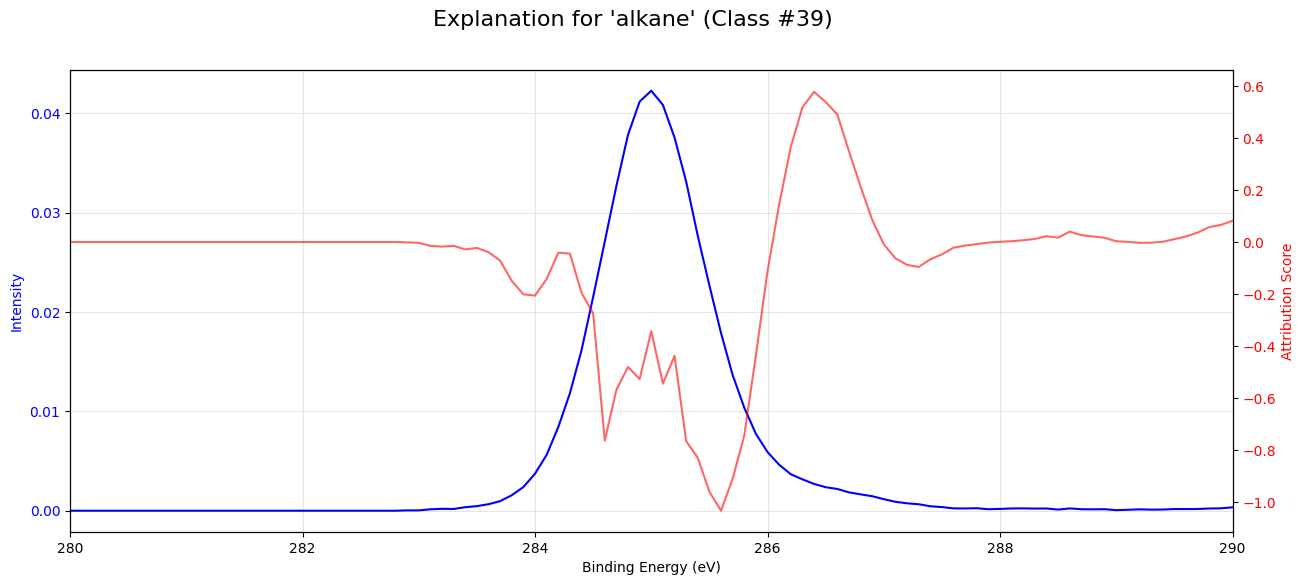

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import torch
from captum.attr import IntegratedGradients

# --- 1. Setup & Data Preparation ---
# Assume FG_list, model_0, X_test, y_test, device, BE_values are defined

# Select a single spectrum and its true label
SAMPLE_INDEX = 12
input_spectrum = X_test[SAMPLE_INDEX].unsqueeze(0).to(device)
true_labels = y_test[SAMPLE_INDEX].to(device)
input_spectrum.requires_grad = True

# --- 2. Get Model Predictions for the Input Spectrum ---
model_0.eval()
with torch.inference_mode():
    logits, _ = model_0(input_spectrum)
    predictions = torch.round(torch.sigmoid(logits)).squeeze()

# --- NEW: Create and Display a Prediction Summary DataFrame ---
true_labels_np = true_labels.cpu().numpy()
predictions_np = predictions.cpu().numpy()

df = pd.DataFrame({
    'Functional Group': FG_list,
    'Actual': true_labels_np,
    'Predicted': predictions_np
})

summary_df = df[(df['Actual'] == 1) | (df['Predicted'] == 1)]

print("--- Prediction Summary for Sample #{} ---".format(SAMPLE_INDEX))
print(summary_df.to_string(index=False))
print("-" * 45)

# --- 3. Attribution Preparation ---
positive_class_indices = torch.where(predictions == 1)[0]

if len(positive_class_indices) == 0:
    print("\nNo positive classes were predicted for this spectrum.")
else:
    print(f"\nFound {len(positive_class_indices)} positive predictions. Generating explanations...")

    forward_func = lambda x: model_0(x)[0]
    ig = IntegratedGradients(forward_func)

    # Compute attribution for ALL positive classes
    attributions_all = []
    for class_index in positive_class_indices:
        attribution = ig.attribute(input_spectrum, target=class_index.item())
        attributions_all.append(attribution.squeeze(0).cpu().detach().numpy())
    attributions_all = np.array(attributions_all)  # shape: (#classes, spectrum_length)

    original_spec_np = input_spectrum.squeeze(0).cpu().detach().numpy()

    # --- 4. Peak Detection + Annotation ---
    # Detect peaks on the original spectrum
    peaks, _ = find_peaks(original_spec_np, height=np.max(original_spec_np)*0.1, distance=20)

    # Assign each peak to the class with the highest summed attribution in a small window
    peak_assignments = []
    window = 10  # +/- around peak
    for p in peaks:
        start, end = max(0, p-window), min(len(original_spec_np), p+window)
        scores = attributions_all[:, start:end].sum(axis=1)  # sum attribution in window
        best_class_idx = positive_class_indices[np.argmax(scores)]
        peak_assignments.append((p, FG_list[best_class_idx]))

    # --- 5. Plot Annotated Spectrum ---
    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(BE_values, original_spec_np, color='blue', label='Original Spectrum')
    plt.xlim()
    ax.set_title(f"Automatic Peak Annotation for Sample #{SAMPLE_INDEX}")
    ax.set_xlabel("Binding Energy (eV)")
    ax.set_ylabel("Intensity")
    ax.grid(True, alpha=0.3)

    for p, fg in peak_assignments:
        ax.axvline(BE_values[p], color='red', linestyle='--', alpha=0.5)
        ax.text(BE_values[p], original_spec_np[p]*1.05, fg, rotation=90,
                color='red', ha='center', va='bottom', fontsize=9)

    ax.legend()

    plt.show()

    # --- 6. Continue with your existing per-class plots ---
    for i, class_index in enumerate(positive_class_indices):
        attribution_np = attributions_all[i]

        fig, ax1 = plt.subplots(figsize=(15, 6))
        functional_group_name = FG_list[class_index]
        fig.suptitle(f"Explanation for '{functional_group_name}' (Class #{class_index})", fontsize=16)

        ax1.plot(BE_values, original_spec_np, label='Original Spectrum', color='blue')
        ax1.set_xlabel("Binding Energy (eV)")
        ax1.set_ylabel("Intensity", color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.grid(True, alpha=0.3)

        ax2 = ax1.twinx()
        ax2.plot(BE_values, attribution_np, label='Importance (Attribution)', color='red', alpha=0.6)
        ax2.set_ylabel("Attribution Score", color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        plt.xlim(280, 290)  # Optional zoom
        plt.show()
